## 租金预测

比赛网址：https://www.dcjingsai.com/v2/cmptDetail.html?id=361

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
# import catboost as cb
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error,make_scorer


In [2]:
train = pd.read_csv("./rent_forecast/train.csv",encoding='utf-8')
test = pd.read_csv("./rent_forecast/test_noLabel.csv",encoding='utf-8')

In [3]:
# 查看训练集
train.head()

,ID,位置,出租方式,区,卧室数量,卫的数量,厅的数量,地铁站点,地铁线路,小区名,小区房屋出租数量,居住状态,总楼层,房屋朝向,房屋面积,时间,楼层,装修情况,距离,Label
0,0,118.0,NaN,11.0,1,1,1,4.0,2.0,3072,128.90625,NaN,23.636364,东南,86.279378,1,2,NaN,76.416667,5.602716
1,1,100.0,NaN,10.0,1,0,0,5.8,4.0,3152,132.81250,NaN,38.181818,东,170.456802,1,1,NaN,70.916667,16.977929
2,2,130.0,NaN,12.0,2,2,1,3.7,5.0,5575,42.96875,NaN,29.090909,东南,105.925190,1,0,NaN,57.250000,8.998302
3,3,90.0,NaN,7.0,3,2,2,6.3,2.0,3103,85.93750,NaN,58.181818,南,191.989407,1,2,NaN,65.833333,5.602716
4,4,31.0,NaN,3.0,2,1,1,NaN,NaN,5182,214.84375,NaN,54.545455,东北,104.270109,1,0,NaN,NaN,7.300509


In [4]:
# 查看测试集
test.head()

,ID,位置,出租方式,区,卧室数量,卫的数量,厅的数量,地铁站点,地铁线路,小区名,小区房屋出租数量,居住状态,总楼层,房屋朝向,房屋面积,时间,楼层,装修情况,距离
0,196539,5.0,1.0,10.0,2,1,1,NaN,NaN,6011,382.81250,3.0,60.000000,东,71.168487,4,1,6.0,NaN
1,196540,0.0,NaN,3.0,2,1,1,NaN,NaN,1697,152.34375,NaN,47.272727,东,74.478649,4,1,NaN,NaN
2,196541,9.0,NaN,10.0,3,2,2,7.4,4.0,754,207.03125,NaN,70.909091,东南,140.681893,4,2,NaN,40.083333
3,196542,96.0,NaN,6.0,2,1,1,1.7,5.0,1285,11.71875,NaN,9.090909,南,89.374379,4,0,NaN,38.416667
4,196543,61.0,NaN,6.0,2,1,1,11.4,3.0,4984,35.15625,NaN,21.818182,东南,86.064217,4,1,NaN,59.833333


In [5]:
# 查看训练集和测试集数据大小、数据类型、缺失情况等信息
train.info()
print('-------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196539 entries, 0 to 196538
Data columns (total 20 columns):
ID          196539 non-null int64
位置          196508 non-null float64
出租方式        24230 non-null float64
区           196508 non-null float64
卧室数量        196539 non-null int64
卫的数量        196539 non-null int64
厅的数量        196539 non-null int64
地铁站点        91778 non-null float64
地铁线路        91778 non-null float64
小区名         196539 non-null int64
小区房屋出租数量    195538 non-null float64
居住状态        20138 non-null float64
总楼层         196539 non-null float64
房屋朝向        196539 non-null object
房屋面积        196539 non-null float64
时间          196539 non-null int64
楼层          196539 non-null int64
装修情况        18492 non-null float64
距离          91778 non-null float64
Label       196539 non-null float64
dtypes: float64(12), int64(7), object(1)
memory usage: 30.0+ MB
-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56279 entries, 0 to 56278
Data columns (total 19 columns

In [6]:
# 查看训练集具体缺失百分比
train_missing = (train.isnull().sum()/len(train))*100
train_missing = train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False)
train_missing

装修情况        90.591180
居住状态        89.753688
出租方式        87.671658
距离          53.302907
地铁线路        53.302907
地铁站点        53.302907
小区房屋出租数量     0.509314
区            0.015773
位置           0.015773
dtype: float64

In [7]:
# 查看测试集具体缺失百分比
test_missing = (test.isnull().sum()/len(test))*100
test_missing = test_missing.drop(test_missing[test_missing==0].index).sort_values(ascending=False)
test_missing



装修情况        92.524743
居住状态        92.034329
出租方式        91.167220
距离          52.923826
地铁线路        52.923826
地铁站点        52.923826
小区房屋出租数量     0.039091
区            0.017769
位置           0.017769
dtype: float64

In [8]:
train.drop(['装修情况','居住状态','出租方式'],axis=1,inplace=True)
test.drop(['装修情况','居住状态','出租方式'],axis=1,inplace=True)



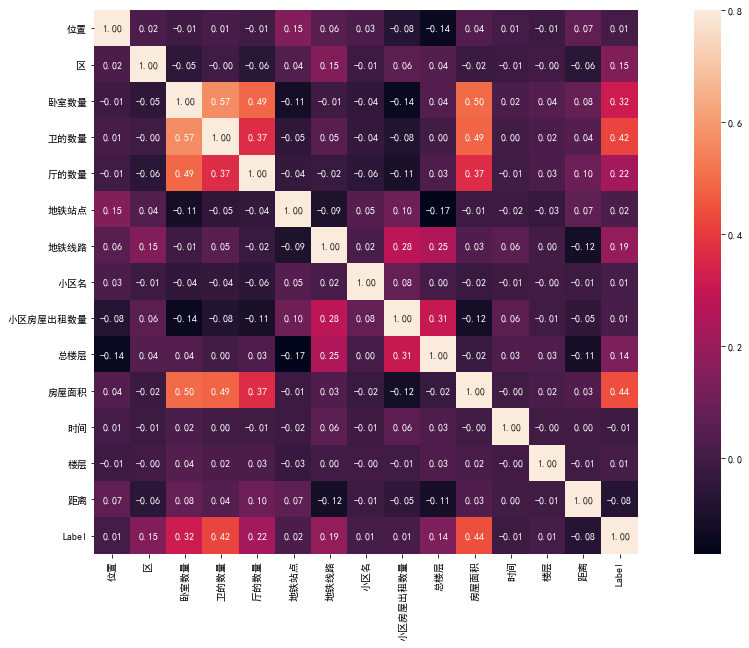

In [9]:
# 查看相关性
columns = train.columns.drop('ID')
correlation = train[columns].corr()
plt.figure(figsize=(20, 10)) 
sns.heatmap(correlation,square = True, annot=True, fmt='0.2f',vmax=0.8)

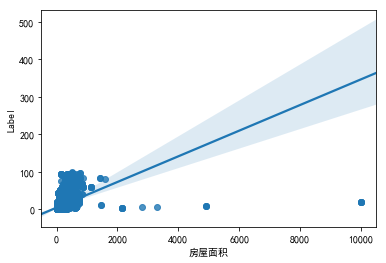

In [10]:
# 房屋面积
sns.regplot(x=train['房屋面积'],y=train['Label'])



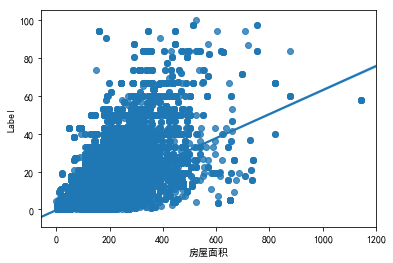

In [11]:
train = train.drop(train[train['房屋面积']>1400].index)
sns.regplot(x=train['房屋面积'],y=train['Label'])

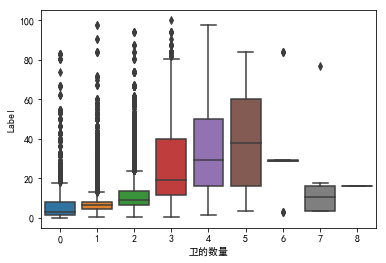

In [12]:
# 卫的数量
sns.boxplot(x=train['卫的数量'],y=train['Label'])



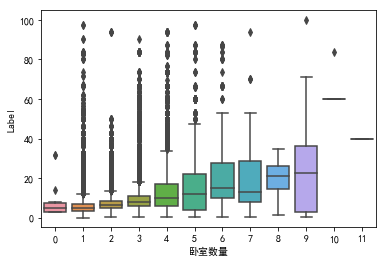

In [13]:
# 卧室数量
sns.boxplot(x=train['卧室数量'],y=train['Label'])

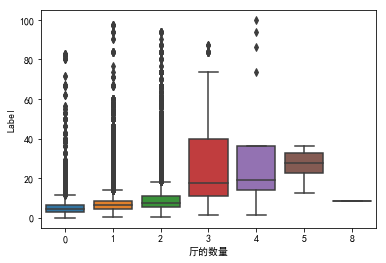

In [14]:
# 厅的数量
sns.boxplot(x=train['厅的数量'],y=train['Label'])

In [ ]:
train['地铁线路'] = train['地铁线路'].fillna(0)


In [15]:
def east(x):
    if ('东' in x and '东南' not in x and '东北' not in x)\
    or ('东' in x and '东南' in x and '东北' not in x and x.count('东')==2)\
    or('东' in x and '东南' not in x and '东北' in x and x.count('东')==2)\
    or ('东' in x and '东南' in x and '东北' in x and x.count('东')==3):
        y = 1
    else:
        y = 0
    return y

def west(x):
    if ('西' in x and '西南' not in x and '西北' not in x)\
    or ('西' in x and '西南' in x and '西北' not in x and x.count('东')==2)\
    or('西' in x and '西南' not in x and '西北' in x and x.count('东')==2)\
    or ('西' in x and '西南' in x and '西北' in x and x.count('东')==3):
        y = 1
    else:
        y = 0
    return y

def south(x):
    if ('南' in x and '东南' not in x and '西南' not in x)\
    or ('南' in x and '东南' in x and '西南' not in x and x.count('东')==2)\
    or('南' in x and '东南' not in x and '西南' in x and x.count('东')==2)\
    or ('南' in x and '东南' in x and '西南' in x and x.count('东')==3):
        y = 1
    else:
        y = 0
    return y

def north(x):
    if ('北' in x and '西北' not in x and '东北' not in x)\
    or ('北' in x and '西北' in x and '东北' not in x and x.count('东')==2)\
    or('北' in x and '西北' not in x and '东北' in x and x.count('东')==2)\
    or ('北' in x and '西北' in x and '东北' in x and x.count('东')==3):
        y = 1
    else:
        y = 0
    return y

train['东']=train['房屋朝向'].apply(lambda x: east(x))
train['西']=train['房屋朝向'].apply(lambda x: west(x))
train['南']=train['房屋朝向'].apply(lambda x: south(x))
train['北']=train['房屋朝向'].apply(lambda x: north(x))
train['东南'] = train['房屋朝向'].apply(lambda x : 1 if '东南' in x else 0)
train['西南'] = train['房屋朝向'].apply(lambda x : 1 if '西南' in x else 0)
train['东北'] = train['房屋朝向'].apply(lambda x : 1 if '东北' in x else 0)
train['西北'] = train['房屋朝向'].apply(lambda x : 1 if '西北' in x else 0)
train.drop('房屋朝向',axis=1,inplace=True)

test['东'] = test['房屋朝向'].apply(lambda x: east(x))
test['西'] = test['房屋朝向'].apply(lambda x: west(x))
test['南'] = test['房屋朝向'].apply(lambda x: south(x))
test['北'] = test['房屋朝向'].apply(lambda x: north(x))
test['东南'] = test['房屋朝向'].apply(lambda x : 1 if '东南' in x else 0)
test['西南'] = test['房屋朝向'].apply(lambda x : 1 if '西南' in x else 0)
test['东北'] = test['房屋朝向'].apply(lambda x : 1 if '东北' in x else 0)
test['西北'] = test['房屋朝向'].apply(lambda x : 1 if '西北' in x else 0)
test.drop('房屋朝向',axis=1,inplace=True)

In [16]:
# 房间总数
train['房间总数'] = train['卫的数量'] + train['卧室数量'] + train['厅的数量']
test['房间总数'] = test['卧室数量'] + test['厅的数量'] + test['卫的数量']

# 每间房间的平均面积
train['平均面积'] = train['房屋面积'] / train['房间总数']
test['平均面积'] = test['房屋面积'] / test['房间总数']

# 卫的面积
train['卫的面积'] = train['房屋面积']*(train['卫的数量']/train['房间总数'])
test['卫的面积'] = test['房屋面积']*(test['卫的数量']/test['房间总数'])

# 卧室面积
train['卧室面积'] = train['房屋面积']*(train['卧室数量']/train['房间总数'])
test['卧室面积'] = test['房屋面积']*(test['卧室数量']/test['房间总数'])

# 厅的面积
train['厅的面积'] = train['房屋面积']*(train['厅的数量']/train['房间总数'])
test['厅的面积'] = test['房屋面积']*(test['厅的数量']/test['房间总数'])

# 楼层比
train['楼层比'] = (train['楼层'] + 1) / train['总楼层']
test['楼层比'] = (test['楼层'] + 1) / test['总楼层']

# 每个小区附近的地铁站点数
temp = train.groupby('小区名')['地铁站点'].count().reset_index()
temp.columns = ['小区名','地铁站点数量']
train = train.merge(temp, how = 'left',on = '小区名')
test = test.merge(temp, how = 'left',on = '小区名')

# 每个小区出租房源的平均房屋面积
area_mean = train.groupby('小区名')['房屋面积'].mean().reset_index()
area_mean.columns = ['小区名','小区房屋平均面积']
train = train.merge(area_mean, how = 'left',on = '小区名')
test = test.merge(area_mean, how = 'left',on = '小区名')

# 每个小区楼房的平均楼层高度
height_mean = train.groupby('小区名')['总楼层'].mean().reset_index()
height_mean.columns = ['小区名','小区楼房平均高度']
train = train.merge(height_mean, how = 'left',on = '小区名')
test = test.merge(height_mean, how = 'left',on = '小区名')

In [17]:
train.columns

Index(['ID', '位置', '区', '卧室数量', '卫的数量', '厅的数量', '地铁站点', '地铁线路', '小区名',
       '小区房屋出租数量', '总楼层', '房屋面积', '时间', '楼层', '距离', 'Label', '东', '西', '南',
       '北', '东南', '西南', '东北', '西北', '房间总数', '平均面积', '卫的面积', '卧室面积', '厅的面积',
       '楼层比', '地铁站点数量', '小区房屋平均面积', '小区楼房平均高度'],
      dtype='object')

In [18]:
feature_cols = ['位置', '区', '卧室数量', '卫的数量', '厅的数量', '地铁站点', '地铁线路', '小区名',
       '小区房屋出租数量', '总楼层', '房屋面积', '时间', '楼层', '距离', '东', '西', '南',
       '北', '东南', '西南', '东北', '西北', '房间总数', '平均面积', '卫的面积', '卧室面积', '厅的面积',
       '楼层比', '地铁站点数量', '小区房屋平均面积', '小区楼房平均高度']

In [19]:
# 提取特征列，标签列构造训练样本和测试样本
X_data = train[feature_cols]
Y_data = train['Label']
X_test  = test[feature_cols]
print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (196519, 31)
X test shape: (56279, 31)


In [20]:
def build_model_xgb(x_train,y_train):
    estimator = xgb.XGBRegressor(max_depth=10,subsample=0.7,colsample_bytree=0.75,reg_lambda=0.1,n_estimators=300)
    param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2]}
    model = GridSearchCV(estimator, param_grid)
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 300)
    param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2]}
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [21]:
# 划分数据集
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [22]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MSE_lgb = mean_squared_error(y_val,val_lgb)
print('MSE of val with lgb:',MSE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)

Train lgb...
MSE of val with lgb: 2.551273553315978
Predict lgb...


In [23]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MSE_xgb = mean_squared_error(y_val,val_xgb)
print('MSE of val with xgb:',MSE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)

Train xgb...
MSE of val with xgb: 2.2201173965226744
Predict xgb...


In [24]:
sub_lgb = pd.DataFrame()
sub_lgb['ID'] = test.ID
sub_lgb['Label'] = subA_lgb
sub_lgb.to_csv("./sub_lgb.csv",index=False,encoding='utf-8')

sub_xgb = pd.DataFrame()
sub_xgb['ID'] = test.ID
sub_xgb['Label'] = subA_xgb
sub_xgb.to_csv("./sub_xgb.csv",index=False,encoding='utf-8')

In [25]:
# 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)

Stack_X_train = pd.DataFrame()
Stack_X_train['Method_1'] = train_lgb_pred
Stack_X_train['Method_2'] = train_xgb_pred

Stack_X_val = pd.DataFrame()
Stack_X_val['Method_1'] = val_lgb
Stack_X_val['Method_2'] = val_xgb

Stack_X_test = pd.DataFrame()
Stack_X_test['Method_1'] = subA_lgb
Stack_X_test['Method_2'] = subA_xgb

In [26]:
# 第二层 
def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

model_lr_Stacking = build_model_lr(Stack_X_train,y_train)
# 训练集
train_pre_Stacking = model_lr_Stacking.predict(Stack_X_train)
print('MSE of Stacking-LR:',mean_squared_error(y_train,train_pre_Stacking))

# 验证集
val_pre_Stacking = model_lr_Stacking.predict(Stack_X_val)
print('MSE of Stacking-LR:',mean_squared_error(y_val,val_pre_Stacking))

# 预测集
print('Predict Stacking-LR...')
subA_Stacking = model_lr_Stacking.predict(Stack_X_test)

MSE of Stacking-LR: 0.5044875260441449
MSE of Stacking-LR: 2.337762253831238
Predict Stacking-LR...


In [27]:
sub_stack = pd.DataFrame()
sub_stack['ID'] = test.ID
sub_stack['Label'] = subA_Stacking
sub_stack.to_csv("./sub_stacking.csv",index=False,encoding='utf-8')
